In [ ]:
# Simulating Squid Biomass Responses to Climate Variability Using an Environmentally Dependent Surplus Production Model: 

# Environmentally Dependent  Surplus  Production Model (EDSP) = P= r*N*(1− K/N )*E
# - P = Surplus production (the amount of biomass produced above maintenance needs)
# - 𝑟 = Intrinsic growth rate of the population
# - 𝑁 = Current population size (biomass)
# - 𝐾 = Carrying capacity (the maximum population size that the environment can sustain)
# - E = Environmental factor(s) that influence productivity (this could be a function of various environmental variables).

# EDSP is used to estimate the amount of biomass that a population can produce above its maintenance needs in relation to environmental factors as it can influence the productivity of a biological population."


# --------------------------------------------------
# This notebook trains and evaluates three variants of the GAM:
# - GLBM (Generalized Linear Biomass Model)
# - Linear GAM (Generalized Additive Model _ log_CPUE_plus_1)
# - Gamma GAM (Generalized Additive Model _ log_CPUE_plus_1)
# and one GLM:
# - Tweedie GLM (Generalized Linear Model with df=4 and var_power=2[Gamma_distribution])
# using monthly CPUE, with full diagnostics.

In [1]:
# Loading Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Simulated Parameters
r = 0.5  # intrinsic growth rate
K = 100000  # carrying capacity
N0 = 50000  # initial biomass

In [3]:
# Load and prepare data by calculating monthly effort (days per month) and total catch
df = pd.read_csv("../data/Final_dataset.csv")
required_cols = ["Year","Month","WaterTemp", "Chlor_a_mg_m3", "SqCatch_Kg", "Day"]
df.dropna(subset=required_cols, inplace=True)

# Filter for months 1-6 only (biologically relevant)
df = df[df["Month"].between(1, 6)]


In [4]:
# Calculate monthly effort (days per month) and total catch
df_monthly = df.groupby(['Year', 'Month']).agg({
    'WaterTemp': 'mean',
    'Chlor_a_mg_m3': 'mean',
    'SqCatch_Kg': ['sum', 'count']  # count of days = effort
}).reset_index()
df_monthly.columns = ['Year', 'Month', 'SST', 'ChlA', 'TotalCatch', 'Effort']

# Calculate CPUE = Catch / Effort
df_monthly['CPUE'] = df_monthly['TotalCatch'] / df_monthly['Effort']

In [5]:
# Normalize SST and ChlA once across all scenarios
sst_min, sst_max = df_monthly['SST'].min(), df_monthly['SST'].max()
chla_min, chla_max = df_monthly['ChlA'].min(), df_monthly['ChlA'].max()

df_monthly['E'] = ((df_monthly['SST'] - sst_min) / (sst_max - sst_min)) * 0.6 + \
                   ((df_monthly['ChlA'] - chla_min) / (chla_max - chla_min)) * 0.4

In [6]:
# Scenario 1: Baseline Simulation
biomass = [N0]
P = []
for t in range(len(df_monthly)):
    N_prev = biomass[-1]
    Et = df_monthly['E'].iloc[t]
    Pt = r * N_prev * (1 - N_prev / K) * Et
    N_next = max(N_prev + Pt, 0)
    P.append(Pt)
    biomass.append(N_next)
df_monthly['Biomass'] = biomass[:-1]
df_monthly['Production'] = P

# Scenario 2: +2°C SST increase (linear warming)
df_warm = df_monthly.copy()
df_warm['SST'] += np.linspace(0, 2, len(df_warm))
df_warm['E'] = ((df_warm['SST'] - sst_min) / (sst_max - sst_min)) * 0.6 + \
                ((df_warm['ChlA'] - chla_min) / (chla_max - chla_min)) * 0.4


In [7]:
# Simulate biomass - Scenario 1 (Baseline)
biomass = [N0]
P = []
E_series = df_monthly['E'].values

for t in range(len(E_series)):
    N_prev = biomass[-1]
    Et = E_series[t]
    Pt = r * N_prev * (1 - N_prev / K) * Et
    N_next = max(N_prev + Pt, 0)
    P.append(Pt)
    biomass.append(N_next)

df_monthly['Biomass'] = biomass[:-1]
df_monthly['Production'] = P


In [8]:
# Scenario 2: +2°C SST increase (linear warming)
df_warm = df_monthly.copy()
df_warm['SST'] += np.linspace(0, 2, len(df_warm))
df_warm['E'] = ((df_warm['SST'] - sst_min) / (sst_max - sst_min)) * 0.6 + \
                ((df_warm['ChlA'] - chla_min) / (chla_max - chla_min)) * 0.4

biomass_warm = [N0]
P2 = []
for t in range(len(df_warm)):
    N_prev = biomass_warm[-1]
    Et = df_warm['E'].iloc[t]
    Pt = r * N_prev * (1 - N_prev / K) * Et
    N_next = max(N_prev + Pt, 0)
    P2.append(Pt)
    biomass_warm.append(N_next)
df_warm['Biomass'] = biomass_warm[:-1]
df_warm['Production'] = P2




In [9]:
# Percentage change in biomass
biomass_base = np.array(biomass[:-1])
biomass_warming = np.array(biomass_warm[:-1])
biomass_change_pct = 100 * (biomass_warming - biomass_base) / biomass_base


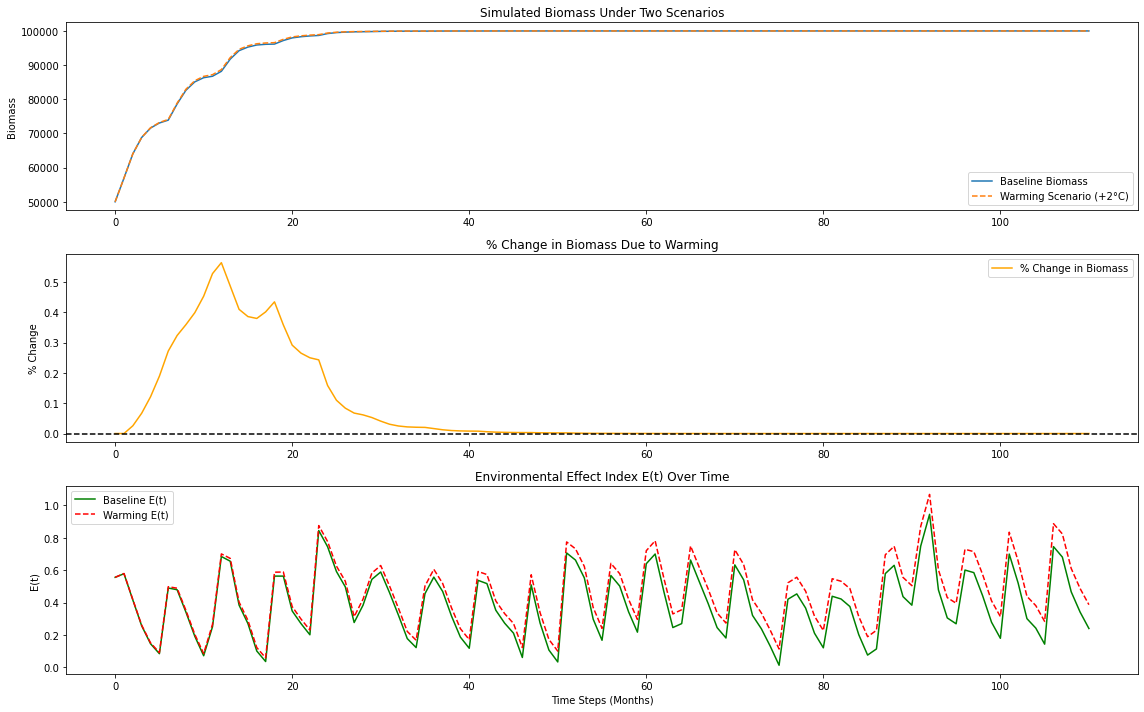

In [10]:
# Plot results
plt.figure(figsize=(16, 10))

plt.subplot(3, 1, 1)
plt.plot(df_monthly['Biomass'], label='Baseline Biomass')
plt.plot(df_warm['Biomass'], label='Warming Scenario (+2°C)', linestyle='--')
plt.title("Simulated Biomass Under Two Scenarios")
plt.ylabel("Biomass")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(biomass_change_pct, label='% Change in Biomass', color='orange')
plt.axhline(0, linestyle='--', color='black')
plt.title("% Change in Biomass Due to Warming")
plt.ylabel("% Change")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_monthly['E'], label='Baseline E(t)', color='green')
plt.plot(df_warm['E'], label='Warming E(t)', color='red', linestyle='--')
plt.title("Environmental Effect Index E(t) Over Time")
plt.ylabel("E(t)")
plt.xlabel("Time Steps (Months)")
plt.legend()

plt.tight_layout()
plt.show()